<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: _______</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


In [ ]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


In [32]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal.windows import tukey
from scipy.signal import butter
from scipy.signal import filtfilt
from scipy.signal import resample
from scipy.signal import spectrogram


#Manipulación del archivo
GWOSC = "/content/H-H1_GWOSC_16KHZ_R1-1266238133-32.txt" #Definimos la ruta al archivo subido a colab
strain = np.loadtxt(GWOSC)#Cargamos la señal





## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

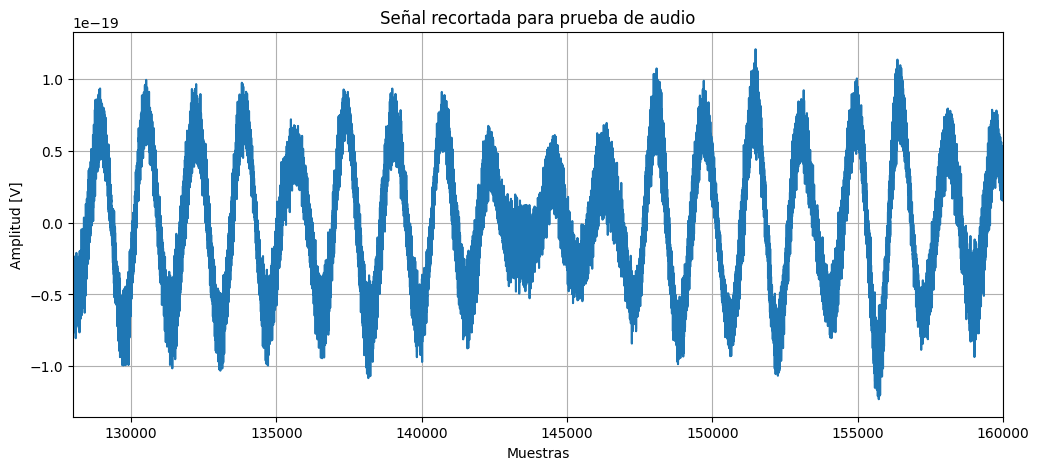

Audio de la señal recortada:


In [156]:
#Parametros del archivo
fs = 16000  #Frecuencia de muestreo en Hz
Ts = 1/fs
t = np.arange(0, len(strain)) * Ts

#Definimos ventana de tiempo entre t1 y t2 como segundos para la cantidad de muestras
t1 = 8 #Decidi usar estos valores ya que suenan más alto que si uso t1 = 20 y t2=22
t2 = 10

#Calculamos la cantidad de muestras en la ventana que definimos
t11 = t1 * fs
t22 = t2 * fs

#Creamos la ventana t1 a t2
ventana = strain[t11:t22] #Ventana de muestras
espaciado = np.linspace(t11, t22, len(ventana)) #Espaciamiento entre muestras

#Graficamos la señal en la ventana de tiempo
plt.figure(figsize=(12, 5))
plt.plot(espaciado, ventana)
plt.xlabel("Muestras")
plt.ylabel("Amplitud [V]")
plt.title("Señal recortada para prueba de audio")
plt.xlim(espaciado[0], espaciado[-1])
plt.grid(True)
plt.show()

#Reproducimos la señal de audio
print("Audio de la señal recortada:")
Audio(ventana, rate=fs)


## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


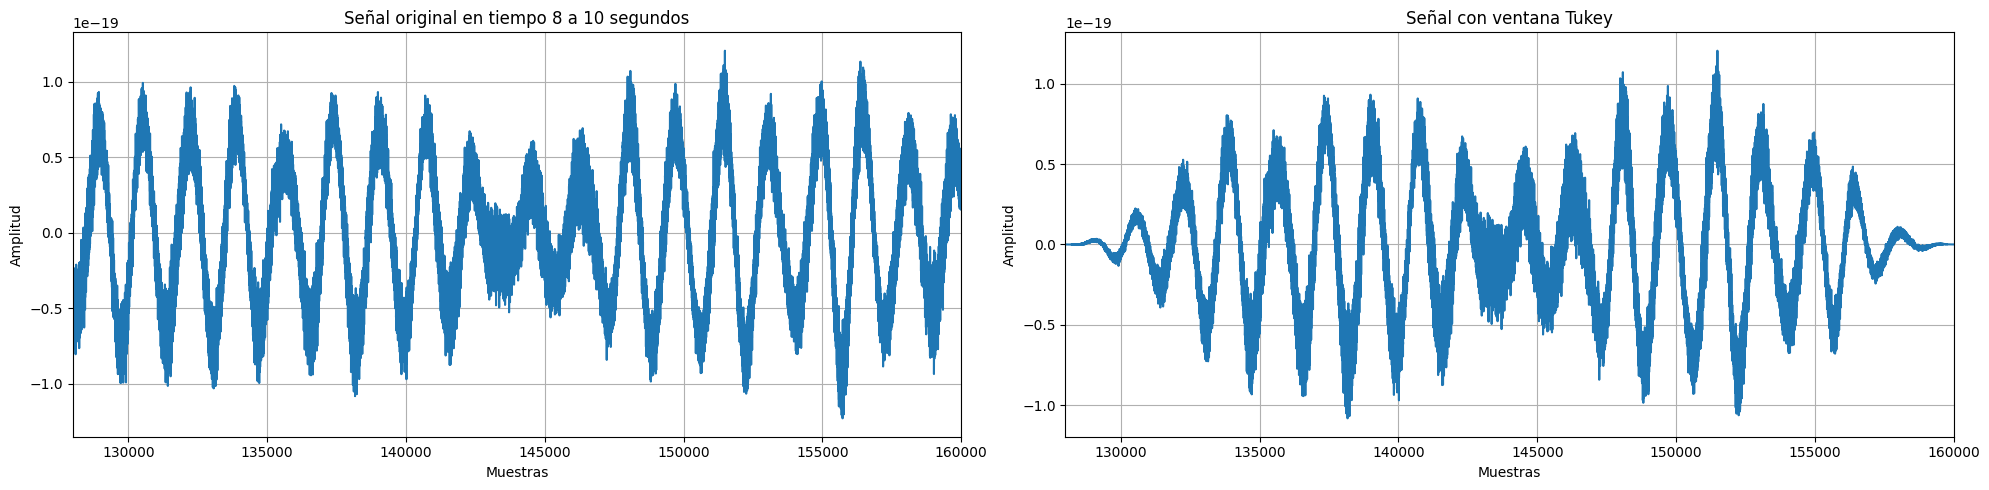

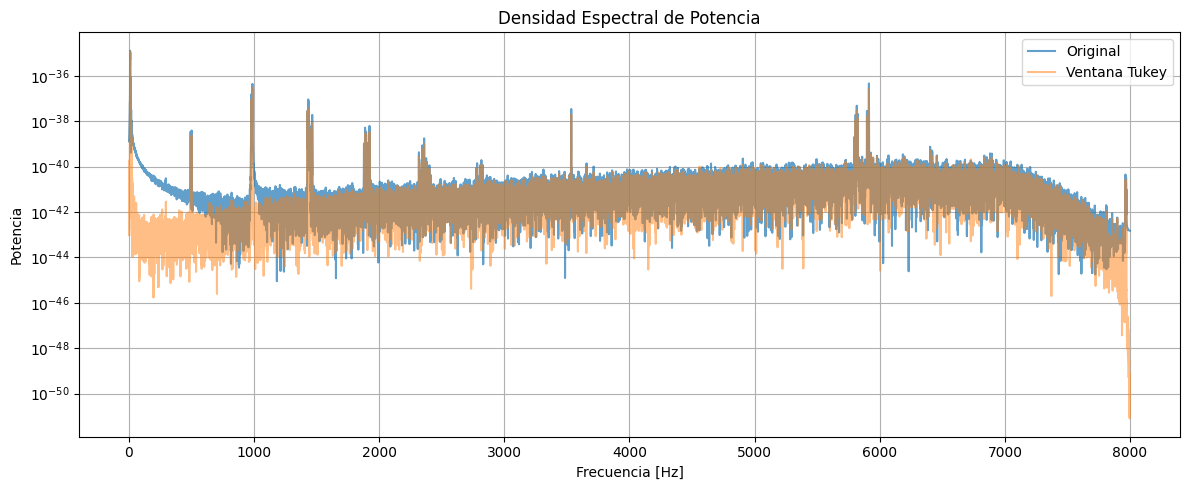

In [155]:

#Calculamos ventana con Tukey antes de la fft para evitar problemas
ventanaTukey = tukey(len(ventana), alpha=0.5)
ventanaFinal = ventana * ventanaTukey

#Aplicamos la FFT
fftVentana = np.fft.fft(ventana)
fftWindowing = np.fft.fft(ventanaFinal)
n = len(ventana)

#Calculamos la densidad espectral de potencia o PSD
psd = (np.abs(fftVentana)**2) / n
psdWindowing = (np.abs(fftWindowing)**2) / n

#Creamos un vector de frecuencias
freqs = np.fft.fftfreq(n, d=1/fs)
Pos = np.arange(1, n // 2)  #Para definir solo la parte positiva y de forma entera redondeamos hacia abajo


#Creamos los plots solicitados

#Graficamos la señal original vs la señal con Windowing
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(espaciado, ventana)
plt.title("Señal original en tiempo 8 a 10 segundos")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.xlim(espaciado[0], espaciado[-1])
plt.tight_layout()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(espaciado, ventanaFinal)
plt.title("Señal con ventana Tukey")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.xlim(espaciado[0], espaciado[-1])
plt.tight_layout()
plt.grid(True)
plt.show()

#Graficamos las PSD en escala logaritmica
plt.figure(figsize=(12, 5))
plt.semilogy(freqs[Pos], psd[Pos], label='Original', alpha = 0.7)
plt.semilogy(freqs[Pos], psdWindowing[Pos], label='Ventana Tukey', alpha = 0.5)
plt.title("Densidad Espectral de Potencia")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Reproducimos el audio con windowing
Audio(ventanaFinal, rate = fs)



## 4. Procesamiento
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


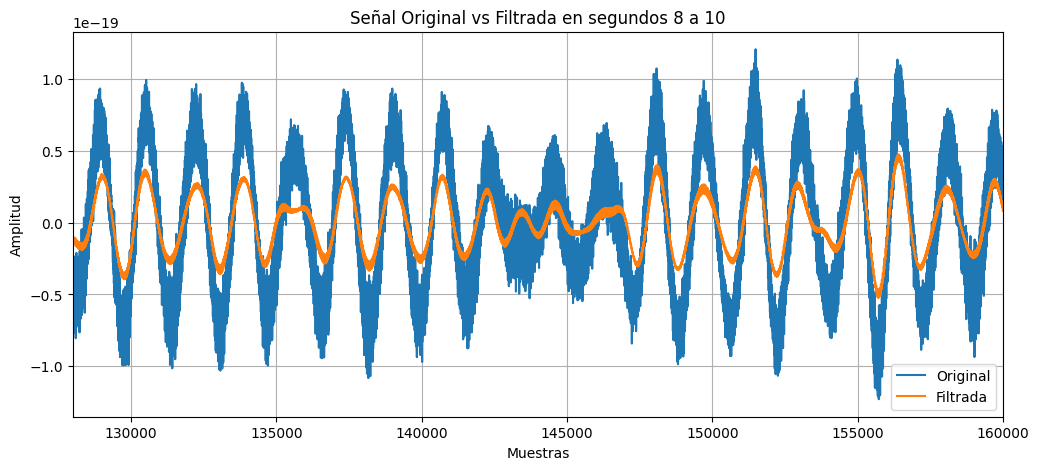

Reproduciendo señal filtrada...


In [152]:
#Definimos el filtro pasabanda
def pasabanda(corteB, corteA, fs, order=4): #Decidi definir una funcion para repasar lo visto en progra2 para programación orientada a objetos
    freqf = 0.5 * fs  #Frecuencia del filtro
    bajo = corteB / freqf
    alto = corteA / freqf
    cB, cA = butter(order, [bajo, alto], btype='band')
    return cB, cA

#Parametros del filtro
corteB = 10  #Frecuencia de corte baja en Hz
corteA = 800 #Frecuencia de corte alta en Hz
cB, cA = pasabanda(corteB, corteA, fs, order=4)

#Aplicamos el filtro a la señal completa
señalFiltrada = filtfilt(cB, cA, strain)
señalFiltrada -= np.mean(señalFiltrada) #Centramos la señal en 0, eliminando la componente continua

ventanaFiltrada = señalFiltrada[t11:t22]

#Graficamos la comparativa de la señal original vs la filtrada
plt.figure(figsize=(12, 5))
plt.plot(espaciado, ventana, label="Original")
plt.plot(espaciado, ventanaFiltrada, label="Filtrada")
plt.xlabel("Muestras")
plt.xlim(espaciado[0], espaciado[-1])
plt.ylabel("Amplitud")
plt.title("Señal Original vs Filtrada en segundos 8 a 10")
plt.legend()
plt.grid(True)
plt.show()

#Reproducimos la señal filtrada
print("Reproduciendo señal filtrada...")
Audio(ventanaFiltrada, rate=fs)


#Diria que lo logico es aplicar una señal pasabanda a la señal, ya que podemos regular las señales
#tanto altas como bajas para encontrar lo que buscamos, en base a esto diseñe mi filtro para obtener un sonido
#sin tanto ruido que permita escuchar mejor la señal, a cambio mi sonido suena mas bajo que el original


# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

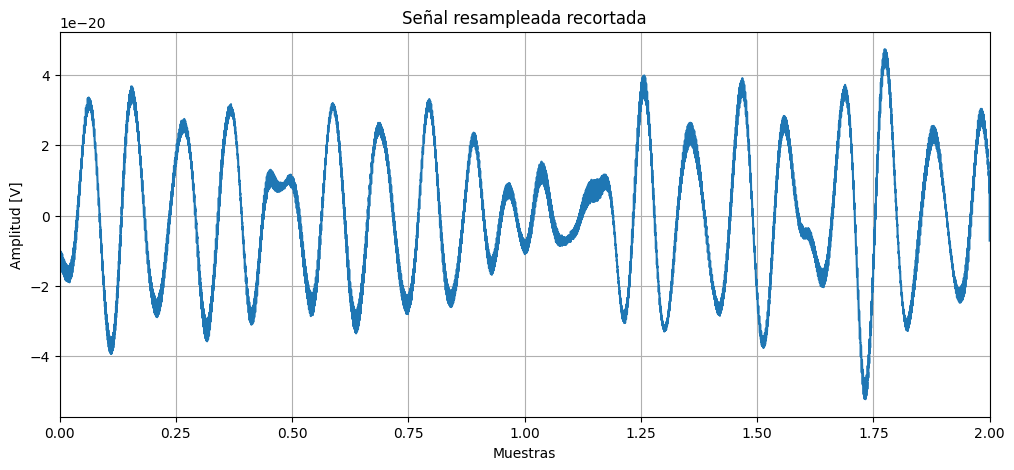

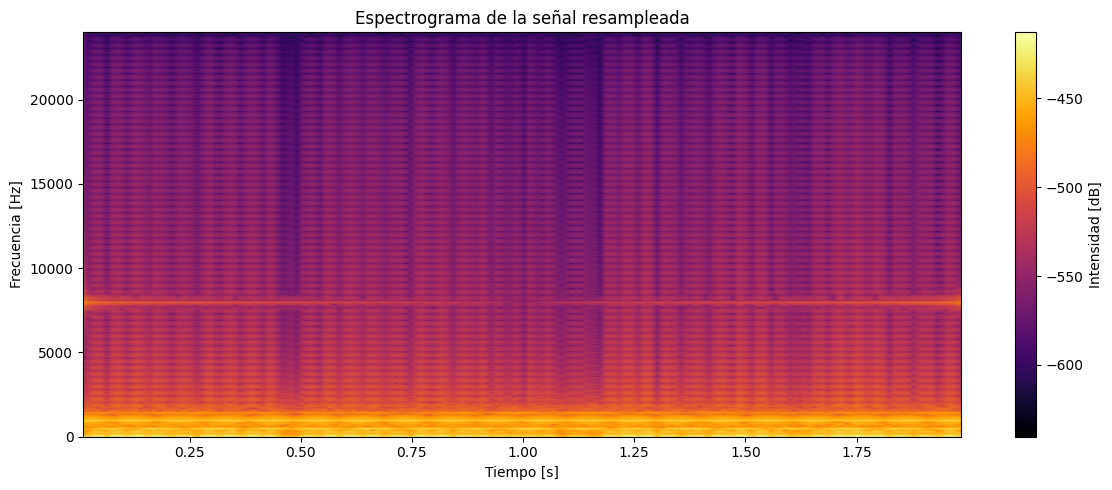

In [158]:
#Parametros del resampleo
fs2 = 3*fs #Frecuencia para resampleo 48kHz

#Definimos la nueva ventana de muestras
t33 = t1 * fs2 #Muestras en tiempo 1
t44 = t2 * fs2 #Muestras en tiempo 2

#Definimos la señal resampleada
resampleada = resample(ventanaFiltrada.real, int(len(ventanaFiltrada) * fs2 / fs))
espaciadoRes = np.linspace(0, len(resampleada) / fs2, len(resampleada)) #Definimos el vector de tiempo para señal resampleada

#Graficamos la señal en la ventana de tiempo
plt.figure(figsize=(12, 5))
plt.plot(espaciadoRes, resampleada)
plt.xlabel("Muestras")
plt.ylabel("Amplitud [V]")
plt.title("Señal resampleada recortada")
plt.grid(True)
plt.xlim(espaciadoRes[0], espaciadoRes[-1])
plt.show()

#Reproducción de audio resampleado
Audio(resampleada, rate = fs2)

from scipy.signal import spectrogram

#Calculamos el espectrograma de la señal resampleada
f, t, Sxx = spectrogram(resampleada, fs=fs2, nperseg=1024, noverlap=512)
#Graficamos el espectrograma
plt.figure(figsize=(12, 5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='inferno')
plt.xlabel("Tiempo [s]")
plt.ylabel("Frecuencia [Hz]")
plt.title("Espectrograma de la señal resampleada")
plt.colorbar(label="Intensidad [dB]")
plt.ylim(0, fs2 / 2)
plt.tight_layout()
plt.show()





